# Breast Cancer Prediction Using Gradient Boosting
## Business Case
The objective of this project is to develop a predictive model to assist in breast cancer diagnosis by identifying critical features that contribute to accurate classification. 

### Key Goals:
1. **Cost Reduction**: Minimize diagnostic testing costs by focusing on the most impactful features.
2. **Efficiency**: Simplify the diagnostic process while maintaining high accuracy.
3. **Scalability**: Create a lightweight and interpretable model suitable for various healthcare settings.

## Dataset Overview
The dataset consists of measurements from digitized images of fine needle aspirates of breast masses. Each row represents a single sample, and features include characteristics such as `radius`, `texture`, `area`, and others, calculated as `mean`, `se`, and `worst`.

### Target Variable:
- **Diagnosis**: Binary classification:
  - `M` = Malignant
  - `B` = Benign

### Importing the data and necessary libraries:

In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') # suppress uneccessary python warnings
import logging

# Redirect LightGBM logs to Python's logging system
lgb.register_logger(logging.getLogger())
logging.getLogger().setLevel(logging.CRITICAL)  # Suppress logs at critical level

# Load Dataset
cancer = pd.read_csv('../data/raw/breast.csv')

In [6]:
# Display first few rows of the dataset
cancer.head()

,ID,Diagnosis,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Data Preprocessing
Steps include:
1. **Rename Columns**: For easier interpretation by adding suffixes (mean, se, worst).
1. **Splitting Data**: Train-test split with stratification to balance the target classes while preserving class proportions.
2. **Balancing Classes**: Using SMOTE (Synthetic Minority Oversampling Technique) to address class imbalance.

In [29]:
# Rename Columns
new_columns = ['ID', 'Diagnosis']
for i in range(30):
    column_name = cancer.columns[i + 2]
    suffix = 'mean' if column_name.endswith('1') else 'se' if column_name.endswith('2') else 'worst'
    new_columns.append(column_name[:-1] + '_' + suffix)
cancer.columns = new_columns

# Prepare Features and Target
X = cancer.drop(columns=['ID', 'Diagnosis'])  # Drop ID and target
y = (cancer['Diagnosis'] == 'M').astype(int)  # Binary encoding: 1 for Malignant, 0 for Benign

# Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Balance the Training Set Using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)



### Show the improvement in class distribution by applying SMOTE:

In [8]:
# Before SMOTE
print("Class distribution before SMOTE:")
print(y_train.value_counts())

# After SMOTE
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())


Class distribution before SMOTE:
Diagnosis
0    267
1    159
Name: count, dtype: int64

Class distribution after SMOTE:
Diagnosis
0    267
1    267
Name: count, dtype: int64


## Hyperparameter tuning using GridSearchCV:

In [ ]:
# Hyperparameter grid for LightGBM
param_grid = {
    'num_leaves': [15, 31],         # Limit leaf complexity
    'min_data_in_leaf': [20, 50],   # Minimum data in each leaf
    'max_depth': [3, 4, 5],         # Limit tree depth
    'learning_rate': [0.05, 0.1],   # Default learning rate
    'n_estimators': [100, 200],     # Number of boosting rounds
}       

# GridSearchCV for hyperparameter tuning
gbm = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', metric='binary_logloss')
grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=0)

# Fit the model
grid_search.fit(X_train_balanced, y_train_balanced)

# Display the best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best AUC: {grid_search.best_score_}")


Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_data_in_leaf': 20, 'n_estimators': 200, 'num_leaves': 15}
Best AUC: 0.9983215326397954


Note: LightGBM ignores `min_child_samples` if `min_data_in_leaf` is set. These LightGBM warnings are expected and harmless. No action is needed.

## Model Training
Now we trained a LightGBM classifier. The model is tuned with specific hyperparameters as per ``GridSearchCV``, ensuring optimal performance.



Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        90
           1       1.00      0.92      0.96        53

    accuracy                           0.97       143
   macro avg       0.98      0.96      0.97       143
weighted avg       0.97      0.97      0.97       143

ROC-AUC Score: 0.9960167714884696


<Figure size 1000x600 with 0 Axes>

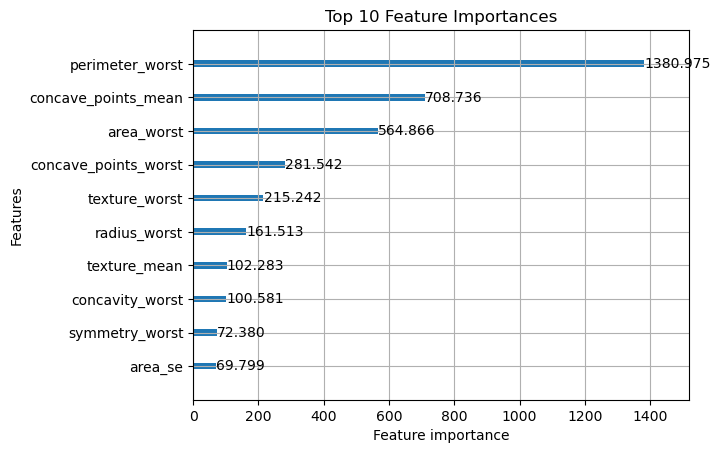

In [31]:
# Set best parameters from GridSearchCV
best_params = grid_search.best_params_

# LightGBM Parameters
params = {
    'boosting_type': 'gbdt',    
    'objective': 'binary',      
    'metric': 'binary_logloss',
}
params.update(best_params)      # Update with GridSearchCV parameters

# Train the Model
gbm = lgb.LGBMClassifier(**params)
gbm.fit(X_train_balanced, y_train_balanced)

# Predictions
y_pred = gbm.predict(X_test)
y_pred_proba = gbm.predict_proba(X_test)[:, 1]

# Evaluation
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

# Feature Importance Plot
plt.figure(figsize=(10, 6))
lgb.plot_importance(gbm, max_num_features=10, importance_type='gain')
plt.title('Top 10 Feature Importances')
plt.show()

### 1. Model Results
Displays the model's classification accuracy, recall, f1-score, support, and ROC-AUC.

In [9]:
# Display evaluation metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        90
           1       1.00      0.92      0.96        53

    accuracy                           0.97       143
   macro avg       0.98      0.96      0.97       143
weighted avg       0.97      0.97      0.97       143

ROC-AUC Score: 0.9960167714884696


#### Note: The ROC-AUC metric was selected because of its relevance when dealing in imbalanced datasets. Also, the high recall indicates there will be fewer missed malignant cases, which is critical with medical data classification.

## Visualizations
### 1. Feature Importance
The below chart shows the top 10 features contributing to the model's performance as per gain.

<Axes: title={'center': 'Top 10 Features'}, xlabel='Feature importance', ylabel='Features'>

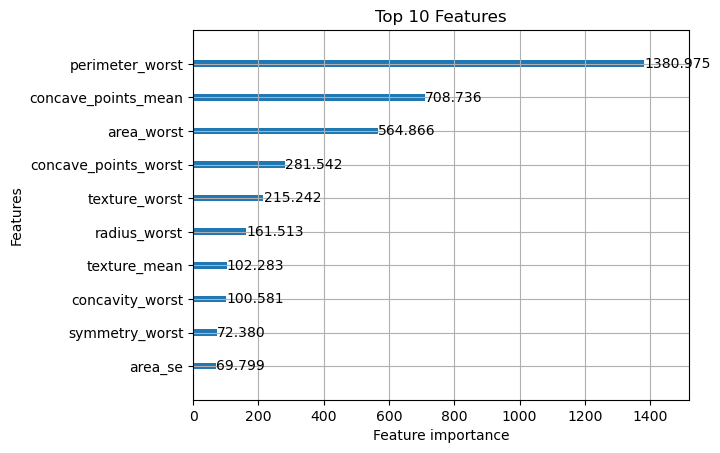

In [10]:
# Display top 10 features based on importance
lgb.plot_importance(gbm, max_num_features=10, importance_type='gain', title="Top 10 Features")

### 2. ROC Curve
Displays the model's ability to distinguish between malignant and benign cases.

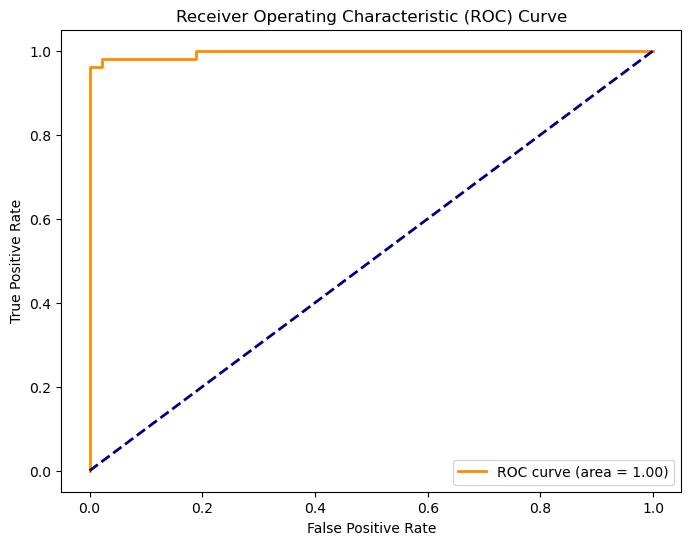

In [11]:
# ROC Curve Plot
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Analysis of Model Performance:

### No Overfitting Indicated:

While the AUC of 1.00 might raise concerns about overfitting, the use of stratified train-test splits and SMOTE for balancing reduces the likelihood of data leakage or overfitting.

### Business Case Fit:

The high AUC ensures that the reduced feature set (top 10 features) is sufficient to maintain excellent diagnostic accuracy, supporting the business case for cost-effective testing.

#### Feature Selection and Cost Reduction
- The model’s feature importance analysis identifies a small subset of high impact features.
- By focusing on these features, diagnostic testing can be streamlined, reducing the number of tests required for accurate classification.
- For instance, instead of evaluating all 30 features, healthcare providers can focus on the top 5 (`perimeter_worst`, `area_worst`, `concave_points_mean`, etc.), significantly lowering costs.
- This supports the business case by balancing cost efficiency with high diagnostic accuracy.

#### Scalability of LightGBM
- **Efficient Training**: LightGBM’s histogram-based algorithm reduces computation time and memory usage, enabling fast model training.
- **Adaptability**: The model performs well on both small and large datasets, making it versatile for different healthcare settings.
- **Portability**: The model’s efficiency makes it suitable for use in resource-limited environments like small clinics.

#### Clinical Relevance of Top Features
- The model identified features like `perimeter_worst`, `area_worst`, and `concave_points_mean` as highly important for diagnosis.
- These features are known in medical research to correlate with tumor characteristics:
  - **`perimeter_worst` and `area_worst`**: Indicate tumor size, often larger in malignant cases.
  - **`concave_points_mean`**: Reflects irregular tumor shapes, a common indicator of malignancy.
- By focusing on these features, the model aligns with clinical intuition, ensuring its predictions are interpretable and trustworthy.


## Conclusion: 

This project successfully developed a LightGBM model for breast cancer diagnosis, achieving a high accuracy of 97% and a ROC-AUC score of 0.996. These metrics ensure reliable diagnostic performance, critical in medical contexts.

The model identifies key features (`perimeter_worst`, `area_worst`, `concave_points_mean`) that align with clinical knowledge, supporting cost reduction by focusing on the most impactful variables. Stratified sampling and SMOTE addressed class imbalance, enhancing the model’s generalizability.

Lightweight and scalable, the model is suitable for deployment in diverse healthcare settings, from hospitals to smaller clinics. Future work could include external validation and the application of explainable AI techniques (e.g., SHAP or LIME) to enhance interpretability and trust among healthcare practitioners.

